In [ ]:
#!unzip /content/drive/MyDrive/HUBMAP/archive.zip -d /content/drive/MyDrive/HUBMAP

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import tifffile 
import os
import cv2 
import tensorflow as tf 
from tqdm import tqdm
import albumentations as A
import zipfile
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Conv2DTranspose
from keras.layers.merge import concatenate #Concatenate (capital C) not working 
#from keras.utils.vis_utils import plot_model
from keras.layers import Dropout

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger , TensorBoard
from tensorflow.keras.metrics import Recall, Precision

from keras.layers import GlobalAveragePooling2D 
from keras.layers import multiply, Reshape
from tensorflow.keras.optimizers import Nadam
from keras.layers import GlobalAveragePooling2D 
from keras.layers import multiply, Reshape
from tensorflow.keras.optimizers import Nadam,Adam
from tensorflow.keras.applications import VGG19
%matplotlib inline 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = concatenate([x, skip_connections[i]])
        x = conv_block(x, f)

    return x
def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPooling2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = concatenate([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = concatenate([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y
def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x
def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = concatenate([outputs1, outputs2])
    #output=Conv2D(1,(2,2),activation="sigmoid",padding="same")(outputs)
    model = Model(inputs, outputs)
    return model
shape=(256,256,3)
model=build_model(shape)

In [ ]:
model.summary()

In [ ]:
#elastic deformation with rotation and small shift for making the model robustness
def Augmentation(images,mask):
    def _transform(image,mask):
        transform=A.Compose([
         A.HorizontalFlip(p=0.25),
         A.VerticalFlip(p=0.25),
         A.RandomRotate90(p=.25),
         A.Transpose(p=0.25),
         A.RandomBrightnessContrast(p=0.5),
         A.ElasticTransform(p=.2, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    ])
        aug=transform(image=image,mask=mask)
        img=aug['image']
        img=tf.cast(img,tf.float64)
        msk=aug['mask']
        msk=tf.cast(msk,tf.float64)
        return img,msk
    image,mask=tf.numpy_function(_transform,[images,mask],[tf.float64,tf.float64])
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    mask.set_shape([IMAGE_SIZE, IMAGE_SIZE, 2])
    
    return image,mask
from glob import glob
IMAGE_SIZE=256
AUTO = tf.data.experimental.AUTOTUNE
def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path, "train/*")))
    print(len(images))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    print(len(masks))
    total_size = len(images)
    valid_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)
(train_x,train_y),(valid_x,valid_y)=load_data('/content/drive/MyDrive/HUBMAP')
train_size=len(train_x)
valid_size=len(valid_x)
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(256,256),interpolation=cv2.INTER_AREA)
    x = x/255.0
    x=tf.cast(x,dtype=tf.float64)
    return x
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(256,256),interpolation=cv2.INTER_NEAREST)
    x = np.expand_dims(x, axis=-1)
    x=np.concatenate([x,x],axis=-1)
    x=tf.cast(x,dtype=tf.float64)
    return x
def parser(x,y):
    def _parse(x,y):
        x=read_image(x)
        y=read_mask(y)
        return x,y
    x,y = tf.numpy_function(_parse, [x,y], [tf.float64,tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 2])
    return x,y
    
def tf_dataset(x, y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(parser)
    dataset = dataset.map(Augmentation)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(AUTO) 
    return dataset
train_dataset=tf_dataset(train_x,train_y,batch=8)
valid_dataset=tf_dataset(valid_x,valid_y,batch=8)

3849
3849


In [ ]:
print(train_dataset)
print(valid_dataset)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 2)), types: (tf.float64, tf.float64)>
<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 2)), types: (tf.float64, tf.float64)>


# loss functions 


In [ ]:
from tensorflow.keras.losses import binary_crossentropy
smooth = 1e-10
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def binary_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)

def binary_dice_loss(y_true, y_pred):
    d_loss= dice_loss(y_true, y_pred)
    b_loss= binary_loss(y_true, y_pred)
    loss=(d_loss+b_loss)
    return loss

def Tversky_Index(y_true,y_pred,smooth):
    y_true= tf.keras.layers.Flatten()(y_true)
    y_pred= tf.keras.layers.Flatten()(y_pred)
    true_positive= tf.reduce_sum(y_true*y_pred)
    false_negative=tf.reduce_sum(y_true*(1-y_pred))
    false_positive=tf.reduce_sum((1-y_true)*y_pred)
    alpha=.7
    TI=(true_positive+smooth)/(true_positive+alpha*false_negative+(1-alpha)*false_positive+smooth)
    return TI

def Tversky_loss(y_true,y_pred):
    return 1-Tversky_Index(y_true,y_pred,smooth=1)
def focal_Tversky_loss(y_true,y_pred):
    pt_1 = Tversky_Index(y_true, y_pred,smooth=1)
    gamma = 0.75
    return tf.math.pow((1-pt_1), gamma)




#model

In [ ]:


from keras.layers import GlobalAveragePooling2D 
from keras.layers import multiply, Reshape
from tensorflow.keras.optimizers import Nadam

In [ ]:

import tensorflow as tf
model=tf.keras.models.load_model('/content/drive/MyDrive/HUBMAP/modelsVGG256.hd5',custom_objects={
        'dice_loss': dice_loss ,'dice_coef': dice_coef})


In [ ]:
model.compile(loss=dice_loss,optimizer=Adam(lr=.00001),metrics=[dice_coef,Recall(),Precision()])


In [ ]:
filepath= '/content/drive/MyDrive/HUBMAP/modelsVGG256.hd5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7),
    ModelCheckpoint(filepath, monitor='val_loss',verbose=1,mode='min',save_best_only=True),
    CSVLogger("/content/drive/MyDrive/data2.csv"),
    TensorBoard(),
]

In [ ]:
t_steps=train_size//8
v_steps=valid_size//8
history = model.fit(train_dataset, 
                        epochs = 20,
                        steps_per_epoch = t_steps,
                        validation_data = valid_dataset,
                    
                        validation_steps = v_steps,
                    callbacks=callbacks
                 )

Epoch 1/20
385/385 [==============================] - 420s 1s/step - loss: 0.1830 - dice_coef: 0.8170 - recall_1: 0.8902 - precision_1: 0.8744 - val_loss: 0.1885 - val_dice_coef: 0.8115 - val_recall_1: 0.8622 - val_precision_1: 0.9006

Epoch 00001: val_loss improved from inf to 0.18854, saving model to /content/drive/MyDrive/HUBMAP/modelsVGG256.hd5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/HUBMAP/modelsVGG256.hd5/assets
Epoch 2/20
385/385 [==============================] - 405s 1s/step - loss: 0.1790 - dice_coef: 0.8210 - recall_1: 0.8959 - precision_1: 0.8841 - val_loss: 0.1954 - val_dice_coef: 0.8046 - val_recall_1: 0.8665 - val_precision_1: 0.8857

Epoch 00002: val_loss did not improve from 0.18854
Epoch 3/20
385/385 [==============================] - 403s 1s/step - loss: 0.1804 - dice_coef: 0.8196 - recall_1: 0.8950 - precision_1: 0.8736 - val_loss: 0.2048 - val_dice_coef: 0.7952 - val_recall_1: 0.8611 - val_precision_1: 0.8861

Epoch 00003: val_loss did not improve

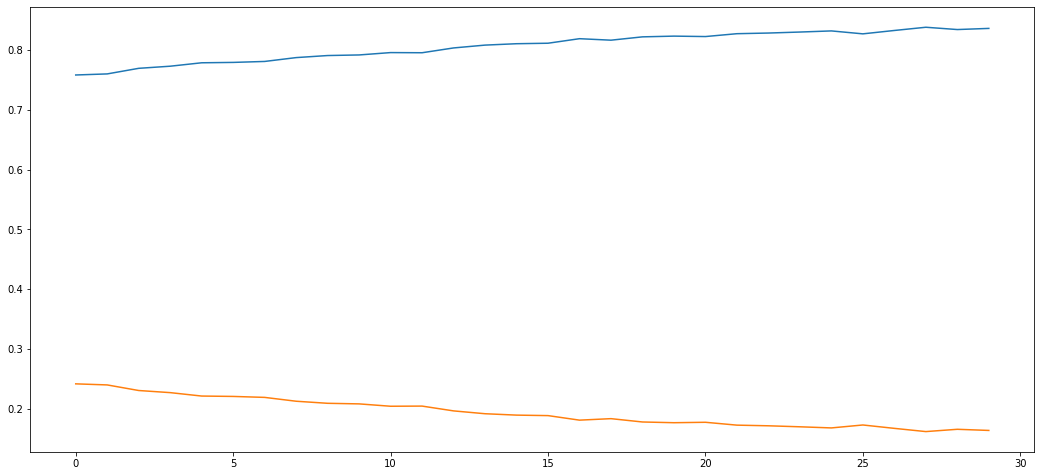

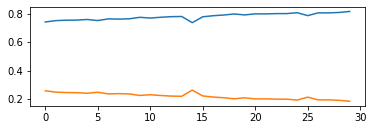

In [ ]:
plt.subplots(figsize=(18,18))
plt.subplot(211)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['loss'])
plt.show()
plt.subplot(212)
plt.plot(history.history['val_dice_coef'])
plt.plot(history.history['val_loss'])

In [ ]:
path=('/content/drive/MyDrive/HUBMAP/train/0486052bb_150.png')
x = cv2.imread(path, cv2.IMREAD_COLOR)
x = cv2.resize(x,(256,256),interpolation=cv2.INTER_AREA)
x = x/255.0
x=np.expand_dims(x,0)
mask=np.squeeze(model.predict(x))
mask=mask[:,:,1]
mask=cv2.resize(mask,(1024,1024))
mask=(mask>0.5).astype(np.uint8)
mask2=cv2.imread('/content/drive/MyDrive/HUBMAP/masks/0486052bb_150.png',cv2.IMREAD_GRAYSCALE)

In [ ]:
np.sum(mask)/np.sum(mask2)

1.010618023414103

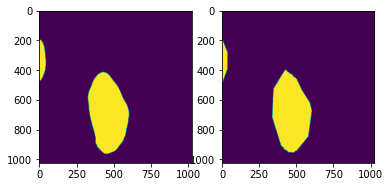

In [ ]:
plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(mask2)